In [ ]:
!pip install -U transformers datasets

In [ ]:
from google.colab import userdata

# Lib Configs
# Invaliate this before sharing
SEED = 42
HF_TOKEN = userdata.get('HF_TOKEN')

# ML Configs
TRAIN_TEST_SPLIT=0.8

In [ ]:
from huggingface_hub import login

login(token=HF_TOKEN)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset
from torchvision.transforms import ToTensor

from tqdm import tqdm

# Load MNIST from Hugging Face
# dataset = load_dataset("kishore-s-15/mnist-with-captions")
dataset = load_dataset("kishore-s-15/mnist-qwen2.5-2B-captions")
dataset = dataset["train"].train_test_split(test_size=TRAIN_TEST_SPLIT, seed=SEED)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
class MNISTTorchDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        image = item["image"]
        label = item["label"]

        if self.transform:
            image = self.transform(image)

        return image, label

train_dataset = MNISTTorchDataset(dataset["train"], transform=transform)
test_dataset = MNISTTorchDataset(dataset["test"], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 112x112
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 56x56
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 28x28
        )
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 14x14
        )
        self.fc1 = nn.Linear(128 * 14 * 14, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [ ]:
import json
import pandas as pd

metrics = {
    "epoch": [],
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": []
}

epochs = 5
for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix(loss=running_loss / (progress_bar.n + 1))

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total * 100

    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = val_correct / val_total * 100

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    # Save metrics
    metrics["epoch"].append(epoch + 1)
    metrics["train_loss"].append(avg_train_loss)
    metrics["train_accuracy"].append(train_accuracy)
    metrics["val_loss"].append(avg_val_loss)
    metrics["val_accuracy"].append(val_accuracy)

with open("cnn_training_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

df_metrics = pd.DataFrame(metrics)
df_metrics.to_csv("cnn_training_metrics.csv", index=False)

Epoch 1 | Train Loss: 0.4605 | Train Acc: 89.73% | Val Loss: 0.1389 | Val Acc: 95.94%


Epoch 2 | Train Loss: 0.1039 | Train Acc: 96.78% | Val Loss: 0.1544 | Val Acc: 95.00%


Epoch 3 | Train Loss: 0.0624 | Train Acc: 97.91% | Val Loss: 0.1537 | Val Acc: 95.46%


Epoch 4 | Train Loss: 0.0469 | Train Acc: 98.42% | Val Loss: 0.0861 | Val Acc: 97.62%


Epoch 5 | Train Loss: 0.0316 | Train Acc: 98.91% | Val Loss: 0.1210 | Val Acc: 97.06%


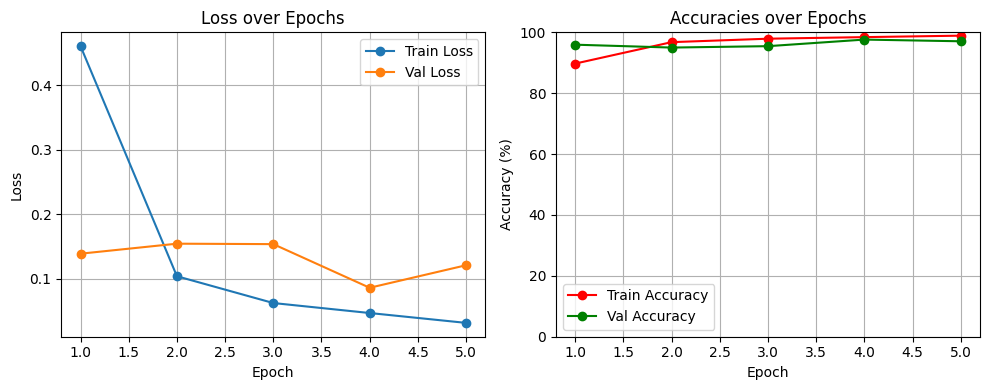

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), df_metrics["train_loss"], label='Train Loss', marker='o')
plt.plot(range(1, epochs + 1), df_metrics["val_loss"], label='Val Loss', marker='o')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), df_metrics["train_accuracy"], label="Train Accuracy", marker='o', color='red')
plt.plot(range(1, epochs + 1), df_metrics["val_accuracy"], label='Val Accuracy', marker='o', color='green')
plt.title("Accuracies over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_plots.png", dpi=300)
plt.show()

In [ ]:
import os

model_path = "simple_cnn_mnist.pth"
torch.save(model.state_dict(), model_path)

In [ ]:
import re
from collections import Counter
from torch.utils.data import Dataset, DataLoader

def simple_tokenizer(text):
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    tokens = text.lower().strip().split()  # space-based split
    return tokens

def build_vocab(texts, min_freq=5):
    counter = Counter()
    for text in texts:
        tokens = simple_tokenizer(text)
        counter.update(tokens)

    vocab = {"<PAD>": 0, "<UNK>": 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

In [ ]:
# dataset = load_dataset("kishore-s-15/mnist-with-captions")
dataset = load_dataset("kishore-s-15/mnist-qwen2.5-2B-captions")
dataset = dataset["train"].train_test_split(test_size=TRAIN_TEST_SPLIT, seed=SEED)

In [ ]:
class TextMNISTDataset(Dataset):
    def __init__(self, hf_dataset, vocab, max_len=7):
        self.dataset = hf_dataset
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        text = self.dataset[idx]['caption']
        label = self.dataset[idx]['label']
        tokens = simple_tokenizer(text)
        token_ids = [self.vocab.get(token, self.vocab["<UNK>"]) for token in tokens]
        token_ids = token_ids[:self.max_len]
        pad_len = self.max_len - len(token_ids)
        token_ids += [self.vocab["<PAD>"]] * pad_len
        return torch.tensor(token_ids), torch.tensor(label)

In [ ]:
class TextBiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes=10, num_layers=2, dropout=0.5):
        super(TextBiLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # 2 for bidirection

    def forward(self, x):
        embedded = self.embedding(x)  # (B, L, D)
        outputs, (hn, cn) = self.lstm(embedded)  # hn: (2*num_layers, B, H)
        final_hidden = torch.cat((hn[-2], hn[-1]), dim=1)  # (B, 2*H)
        final_hidden = self.dropout(final_hidden)
        out = self.fc(final_hidden)  # (B, C)
        return out

In [ ]:
from tqdm import tqdm

captions = [d['caption'] for d in dataset['train']]
vocab = build_vocab(captions, min_freq=2)

train_dataset = TextMNISTDataset(dataset['train'], vocab)
test_dataset = TextMNISTDataset(dataset['test'], vocab)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TextBiLSTMClassifier(
    vocab_size=len(vocab),
    embed_dim=128,
    hidden_dim=256,
    num_classes=10,
    num_layers=3,
    dropout=0.3
).to(device)

# model = TextTransformerClassifier(
#     vocab_size=len(vocab),
#     embed_dim=128,
#     num_heads=4,
#     num_layers=2,
#     num_classes=10,
#     dropout=0.3,
#     max_len=7
# ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss()

In [ ]:
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import pandas as pd

metrics = {
    "epoch": [],
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": []
}

epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        current_loss = running_loss / (progress_bar.n + 1)
        current_acc = 100 * correct / total
        progress_bar.set_postfix({
            "loss": f"{current_loss:.4f}",
            "acc": f"{current_acc:.2f}%"
        })

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc=f"Validating Epoch {epoch+1}", leave=False)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            current_val_acc = 100 * val_correct / val_total
            current_val_loss = val_loss / (progress_bar.n + 1)
            progress_bar.set_postfix({
                "val_loss": f"{current_val_loss:.4f}",
                "val_acc": f"{current_val_acc:.2f}%"
            })

    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = 100 * val_correct / val_total

    # Store metrics
    metrics["epoch"].append(epoch + 1)
    metrics["train_loss"].append(avg_train_loss)
    metrics["train_accuracy"].append(train_accuracy)
    metrics["val_loss"].append(avg_val_loss)
    metrics["val_accuracy"].append(val_accuracy)

    print(f"Epoch {epoch+1}: "
          f"Train Loss = {avg_train_loss:.4f}, Train Acc = {train_accuracy:.2f}%, "
          f"Val Loss = {avg_val_loss:.4f}, Val Acc = {val_accuracy:.2f}%")

Epoch 1: Train Loss = 0.8368, Train Acc = 73.44%, Val Loss = 0.6525, Val Acc = 79.57%


Epoch 2: Train Loss = 0.6420, Train Acc = 79.45%, Val Loss = 0.6493, Val Acc = 79.57%


Epoch 3: Train Loss = 0.6347, Train Acc = 79.65%, Val Loss = 0.6496, Val Acc = 79.57%


Epoch 4: Train Loss = 0.6338, Train Acc = 79.77%, Val Loss = 0.6450, Val Acc = 79.57%


Epoch 5: Train Loss = 0.6355, Train Acc = 79.70%, Val Loss = 0.6499, Val Acc = 79.57%


In [ ]:
with open("lstm_training_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

df_metrics = pd.DataFrame(metrics)
df_metrics.to_csv("lstm_training_metrics.csv", index=False)

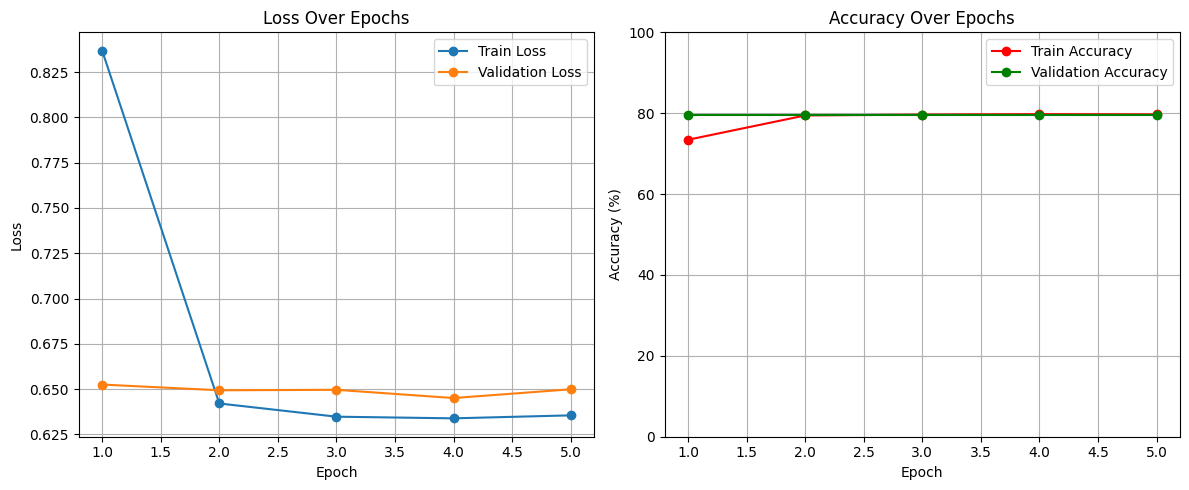

In [ ]:
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(df_metrics["epoch"], df_metrics["train_loss"], label="Train Loss", marker='o')
plt.plot(df_metrics["epoch"], df_metrics["val_loss"], label="Validation Loss", marker='o')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(df_metrics["epoch"], df_metrics["train_accuracy"], label="Train Accuracy", marker='o', color="red")
plt.plot(df_metrics["epoch"], metrics["val_accuracy"], label="Validation Accuracy", marker='o', color="green")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("metrics_over_epochs.png", dpi=300)
plt.show()


In [ ]:
import os

model_path = "simple_lstm_mnist.pth"
torch.save(model.state_dict(), model_path)